In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [187]:
#plot style
sns.set_style('whitegrid')

#palette
sns.set_palette('vlag')

In [188]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [189]:
sale_train = pd.read_csv('/content/drive/MyDrive/DataFlow_Data/train.csv')

sale_train

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,2013-07-31,78773,12,19648.44,12309.747660
1,781,2014-03-12,90501,16,20351.52,13497.128064
2,2090,2013-11-29,44460,26,111367.62,91488.499830
3,1116,2018-08-29,30122,12,36280.44,21967.806420
4,993,2013-04-27,75789,14,55557.18,48645.866808
...,...,...,...,...,...,...
901556,2213,2013-08-12,15135,1,1070.37,749.794185
901557,2213,2011-12-04,80120,1,1070.37,749.794185
901558,2213,2011-05-29,30028,1,1070.37,749.794185
901559,2213,2014-04-01,65279,1,1070.37,749.794185


In [190]:
sale_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901561 entries, 0 to 901560
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ProductID  901561 non-null  int64  
 1   Date       901561 non-null  object 
 2   Zip        901561 non-null  int64  
 3   Units      901561 non-null  int64  
 4   Revenue    901561 non-null  float64
 5   COGS       901561 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 41.3+ MB


In [191]:
sale_test = pd.read_csv('/content/drive/MyDrive/DataFlow_Data/test.csv')

sale_test

,ProductID,Date,Zip,Units,Revenue,COGS
0,1989,2022-06-01,54082,12,65764.44,65159.407152
1,582,2022-03-22,30012,14,59967.18,44705.532690
2,1828,2021-09-11,11377,15,51965.55,46665.063900
3,582,2022-06-01,55128,12,51400.44,38319.028020
4,415,2021-10-11,32174,29,333409.23,312271.084818
...,...,...,...,...,...,...
74677,794,2021-04-09,80602,1,1070.37,1092.312585
74678,794,2021-02-13,80915,1,1070.37,1092.312585
74679,793,2021-08-17,16038,1,1070.37,680.113098
74680,793,2021-02-13,80915,1,1070.37,680.113098


In [192]:
sale_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ProductID  74682 non-null  int64  
 1   Date       74682 non-null  object 
 2   Zip        74682 non-null  int64  
 3   Units      74682 non-null  int64  
 4   Revenue    74641 non-null  float64
 5   COGS       74682 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.4+ MB


# Dataset Overview

In [193]:
print(f'Number of unique ProductID in train.csv are: {len(sale_train.ProductID.unique())}')

print(f'Number of duplicate values in train.csv: {sale_train.duplicated().sum()}')     # check duplicates


Number of unique ProductID in train.csv are: 1624
Number of duplicate values in train.csv: 36


In [194]:
# loại bỏ duplicate
sale_train = sale_train.drop_duplicates()
# check
sale_train.duplicated().sum()

0

In [195]:
var_num = len(sale_train.columns)
observe_num = len(sale_train)

missing_num = sale_train.isnull().sum().sum()                                 # why using 2 .sum()
missing_per = (missing_num/ (var_num*observe_num)) *100

In [196]:
stats = [
        {'Metric': 'Number of variables', 'Value': var_num},
        {'Metric': 'Number of observations', 'Value': observe_num},
        {'Metric': 'Missing cells', 'Value': missing_num},
        {'Metric': 'Missing cells (%)', 'Value': f'{missing_per.sum():.3f}%'}
    ]

stat = pd.DataFrame(stats)

stat

,Metric,Value
0,Number of variables,6
1,Number of observations,901525
2,Missing cells,0
3,Missing cells (%),0.000%


- Dữ liệu khá sạch và không cần clean nhiều

# EDA

In [197]:
sale_train['Date'] = pd.to_datetime(sale_train['Date'])

<ipython-input-197-d80a548def31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sale_train['Date'] = pd.to_datetime(sale_train['Date'])


In [198]:
sale_train.describe()

,ProductID,Date,Zip,Units,Revenue,COGS
count,901525.000000,901525,901525.000000,901525.000000,901525.000000,901525.000000
mean,1233.653906,2014-11-06 19:43:00.016306176,55701.281897,1.030296,5653.093124,4647.482578
min,1.000000,2010-07-04 00:00:00,1001.000000,1.000000,427.770000,214.526655
25%,689.000000,2012-07-22 00:00:00,31014.000000,1.000000,2078.370000,1841.163597
50%,989.000000,2014-06-29 00:00:00,54520.000000,1.000000,4566.240000,3693.018420
75%,2045.000000,2016-08-01 00:00:00,83709.000000,1.000000,8189.370000,6509.314350
max,2412.000000,2020-12-31 00:00:00,99950.000000,44.000000,334548.900000,306918.186750
std,691.331483,NaN,28987.275305,0.327201,4501.316985,3959.422543


In [199]:
sale_col = sale_train.columns.tolist()

sale_col.remove('ProductID')
sale_col.remove('Zip')

## Distribution of each features

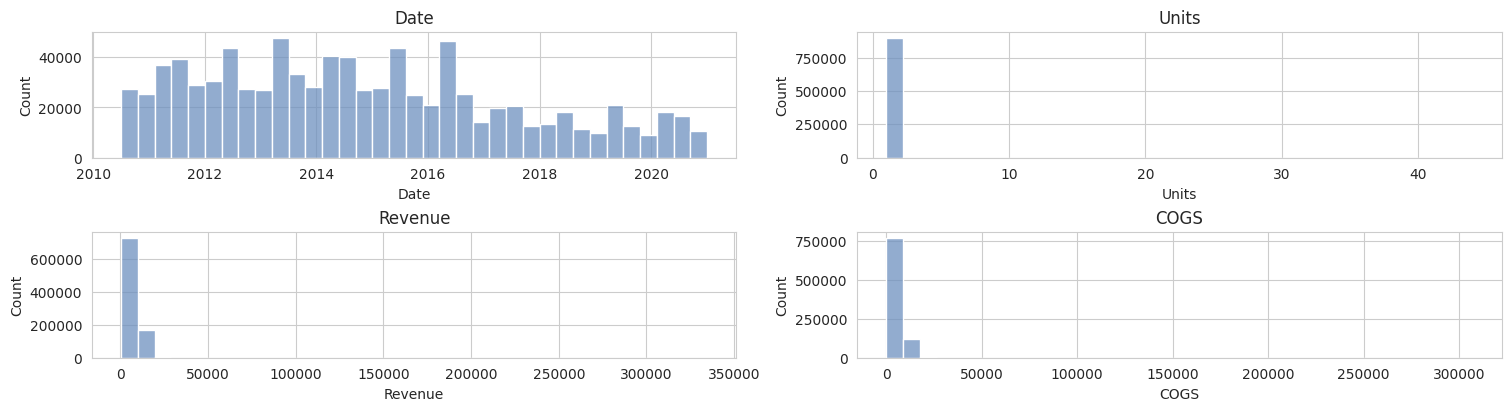

In [200]:
# Historgram of features
ncol, nrow = 2, len(sale_col)//2
fig, axes = plt.subplots(nrow, ncol, figsize=(15, len(sale_col)), constrained_layout=True)

for ax, column in zip(axes.flatten(), sale_col):
    sns.histplot(x=sale_train[column], ax=ax, bins=35)
    ax.set_title(column)

plt.show()

## Checking outliers


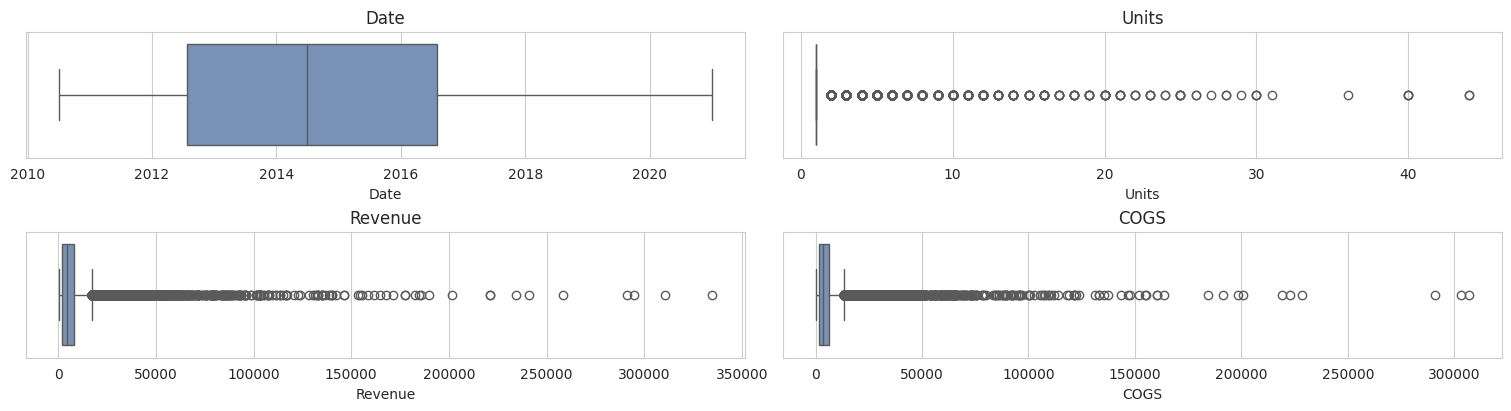

In [201]:
# Boxplot of features
ncol, nrow = 2, len(sale_col)//2
fig, axes = plt.subplots(nrow, ncol, figsize=(15, len(sale_col)), constrained_layout=True)

for ax, column in zip(axes.flatten(), sale_col):
    sns.boxplot(x=sale_train[column], ax=ax)
    ax.set_title(column)

plt.show()

## How date impact target

### Group based on day

In [202]:
# Set 'Date' column as index for Time Series Analysis
sale_train.set_index('Date', inplace=True)

# Sort by date
sale_train.sort_index(inplace=True)

sale_train.head()

<ipython-input-202-325a6c960e77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sale_train.sort_index(inplace=True)


,ProductID,Zip,Units,Revenue,COGS
Date,,,,,
2010-07-04,2277,18947,1,3716.37,4063.478958
2010-07-04,2251,34688,1,1511.37,1150.605981
2010-07-04,485,47380,1,10218.60,10973.754540
2010-07-04,1935,2886,2,3274.74,2133.165636
2010-07-04,1105,95075,1,2960.37,2932.542522


In [204]:
daily_revenue = sale_train.groupby('Date')['Revenue'].sum().reset_index()

In [205]:
daily_revenue.head()

,Date,Revenue
0,2010-07-04,1765391.67
1,2010-07-05,1425986.10
2,2010-07-06,302463.00
3,2010-07-07,1047787.65
4,2010-07-08,771811.74


In [206]:
def plot_yearly_revenue(daily_revenue, year):
    daily_revenue['Date'] = pd.to_datetime(daily_revenue['Date'])  # Ensure Date is datetime
    filtered_data = daily_revenue[daily_revenue['Date'].dt.year == year]

    plt.figure(figsize=(15, 10))
    plt.plot(filtered_data['Date'], filtered_data['Revenue'], marker='o', color='#30c3cd', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title(f'Daily Revenue in {year}')
    plt.grid(True, linestyle='--')
    plt.show()

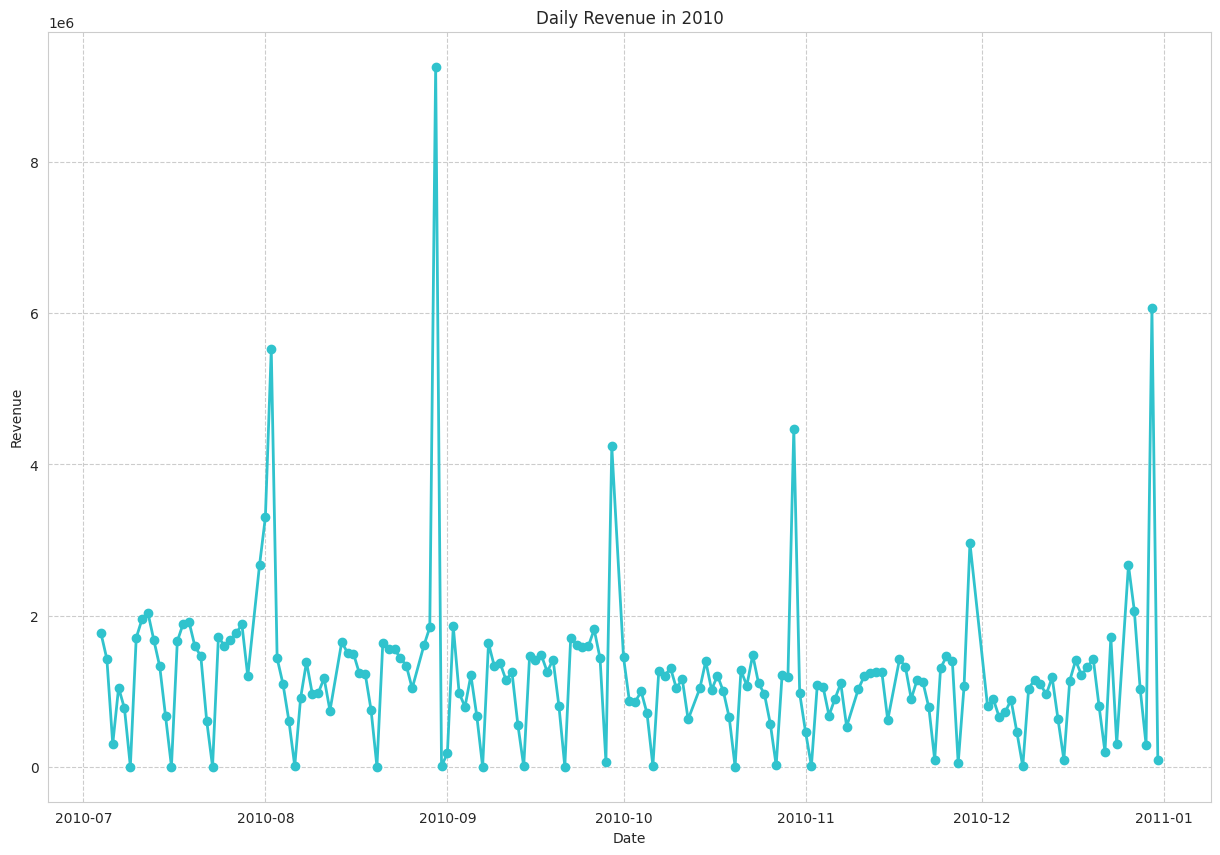

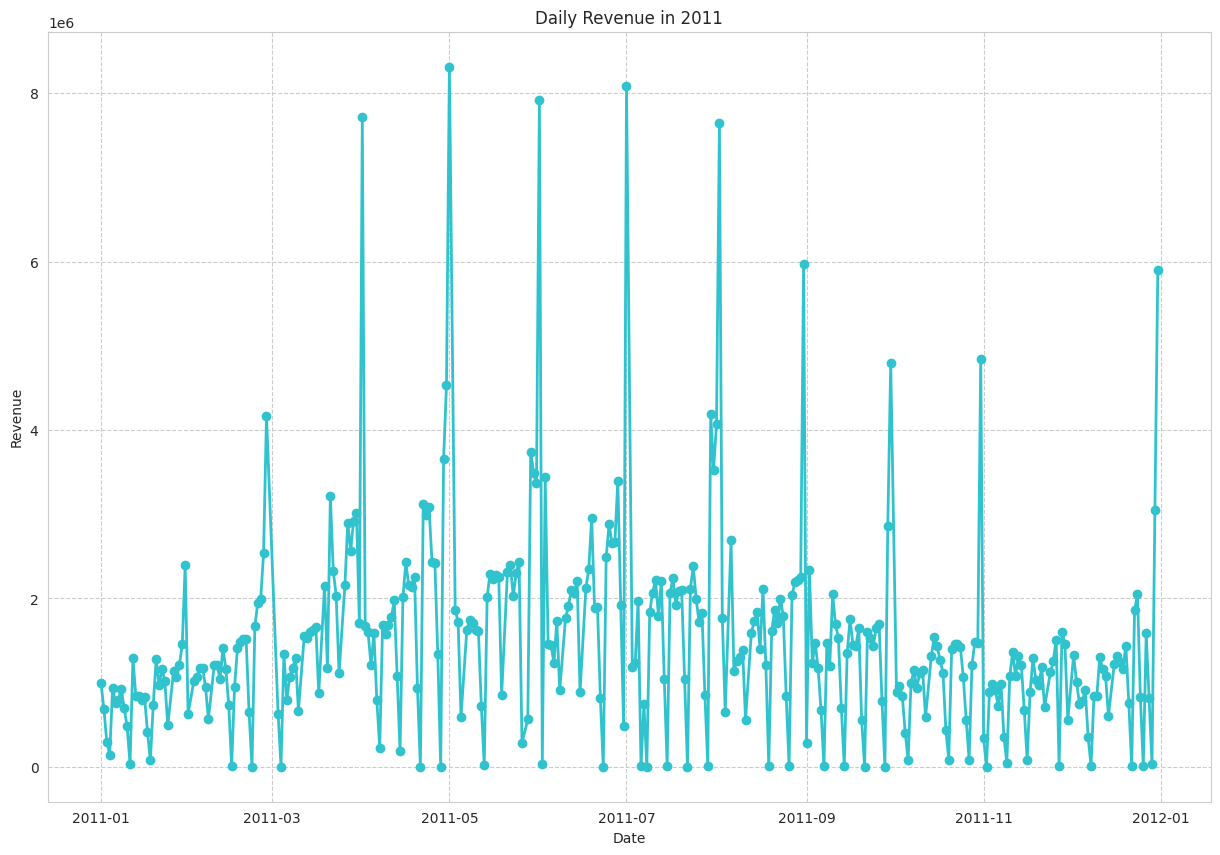

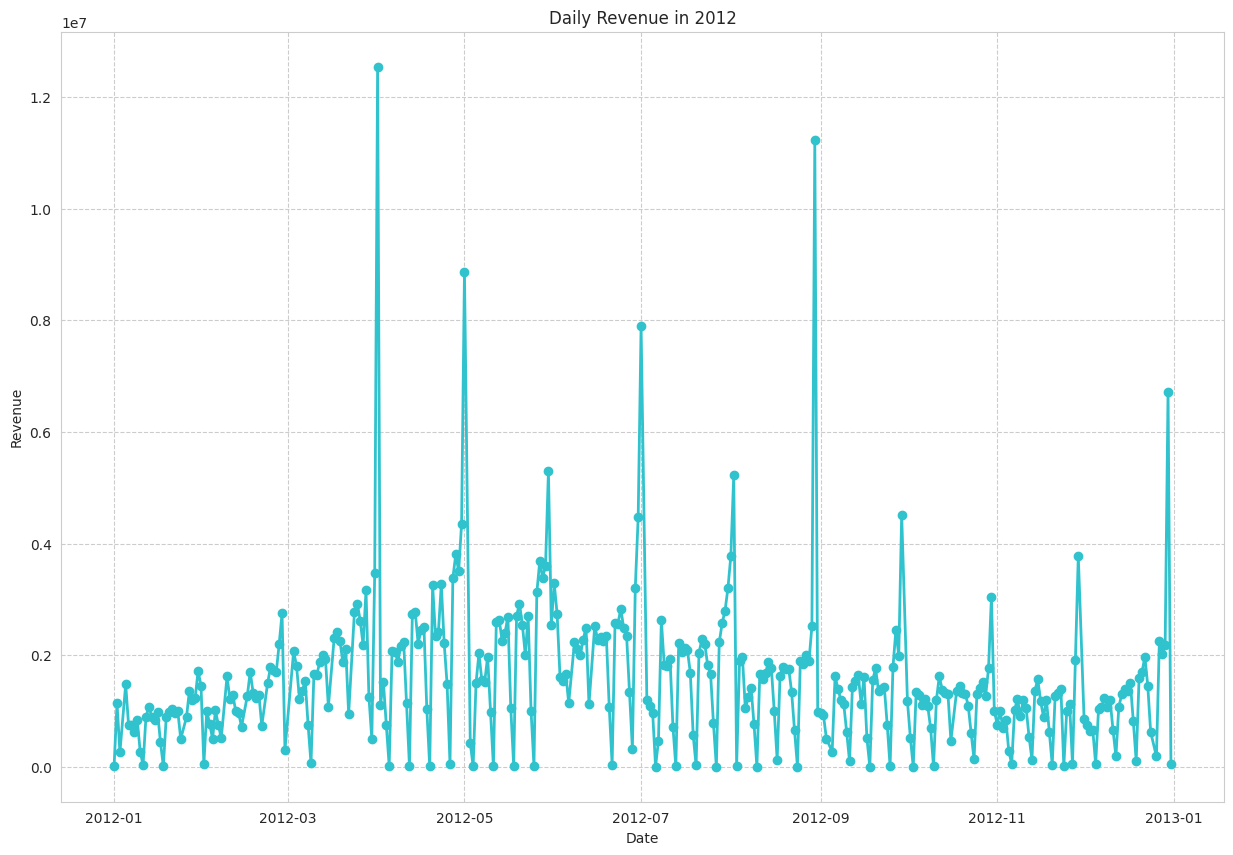

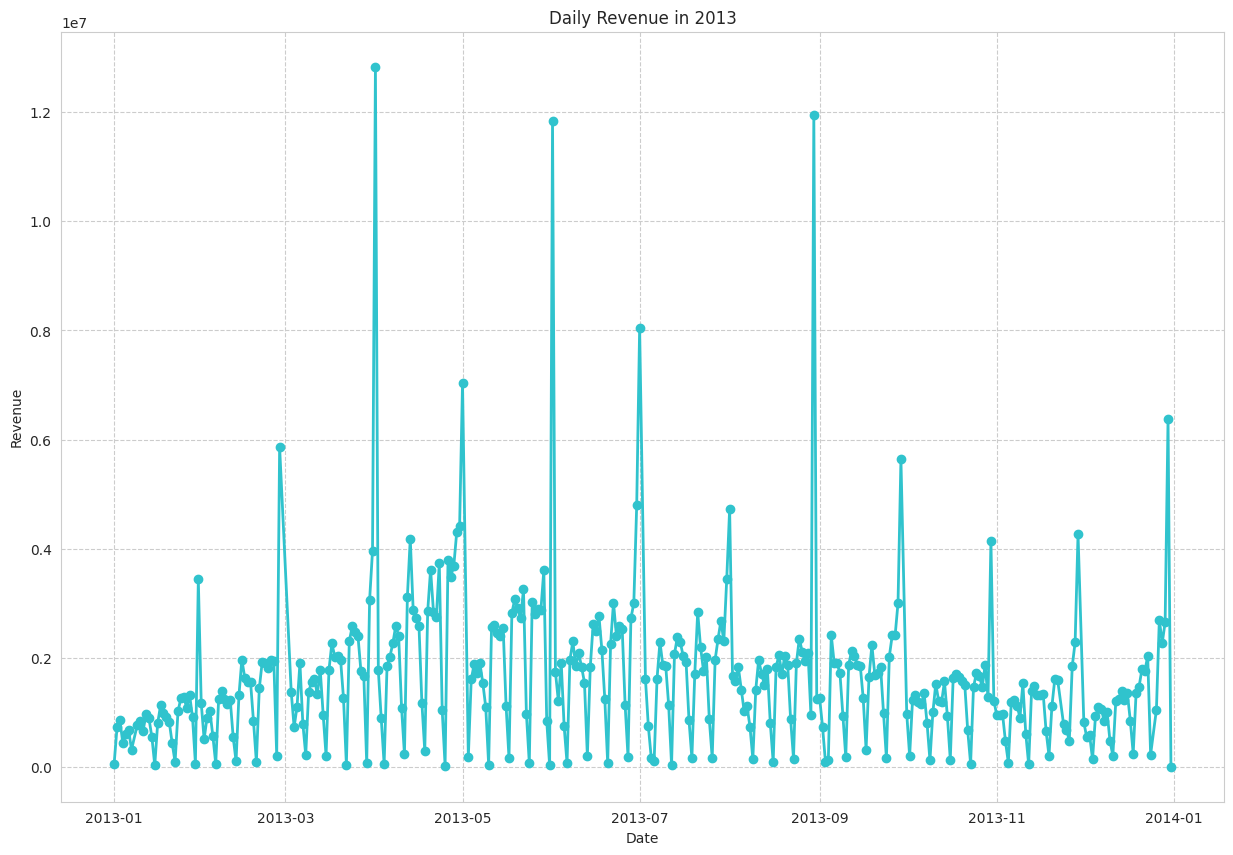

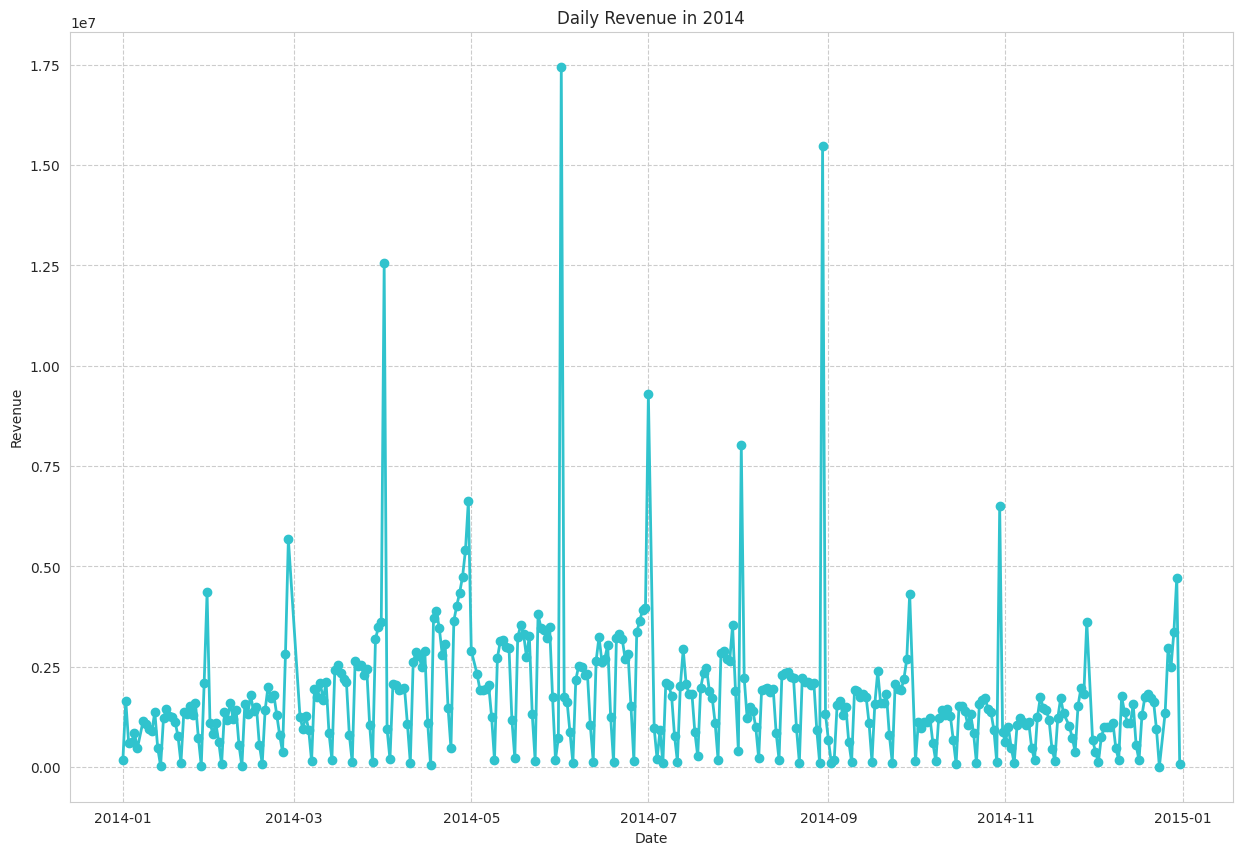

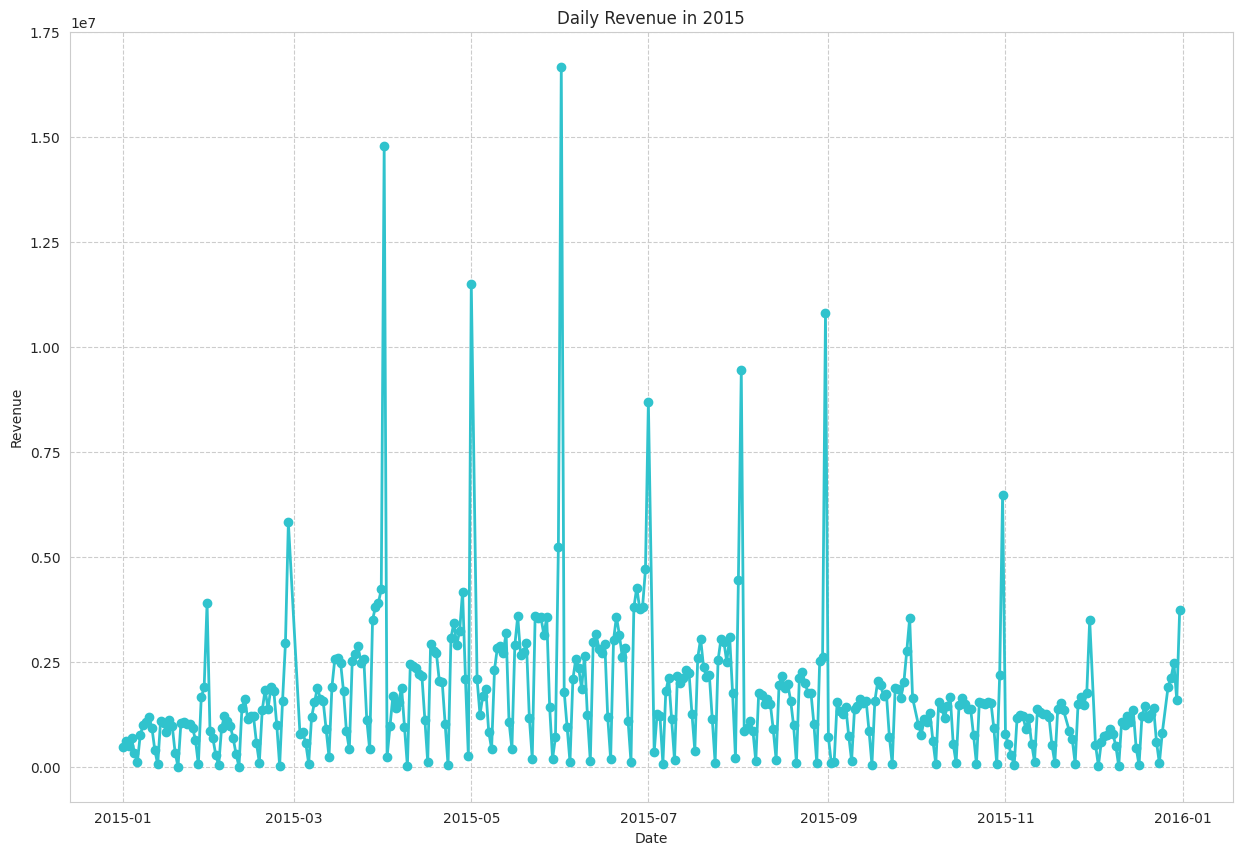

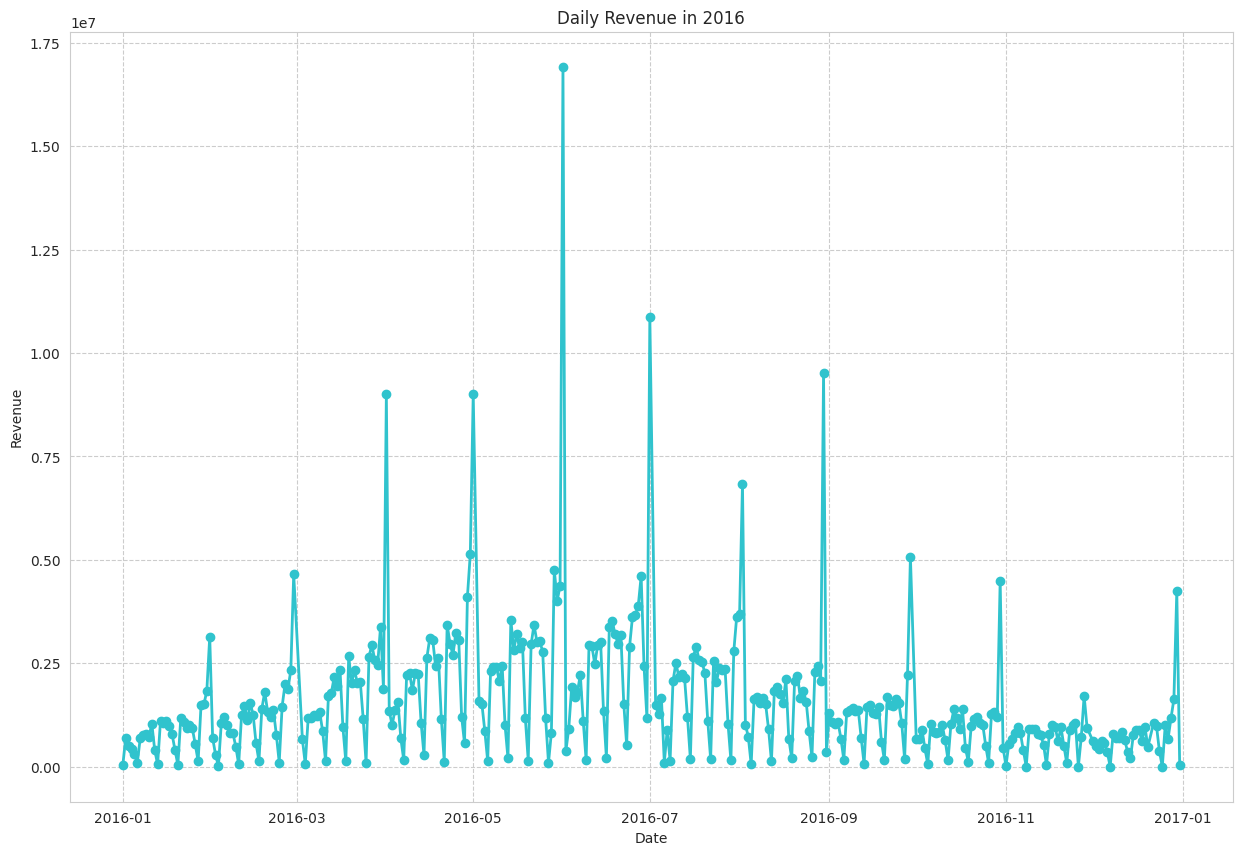

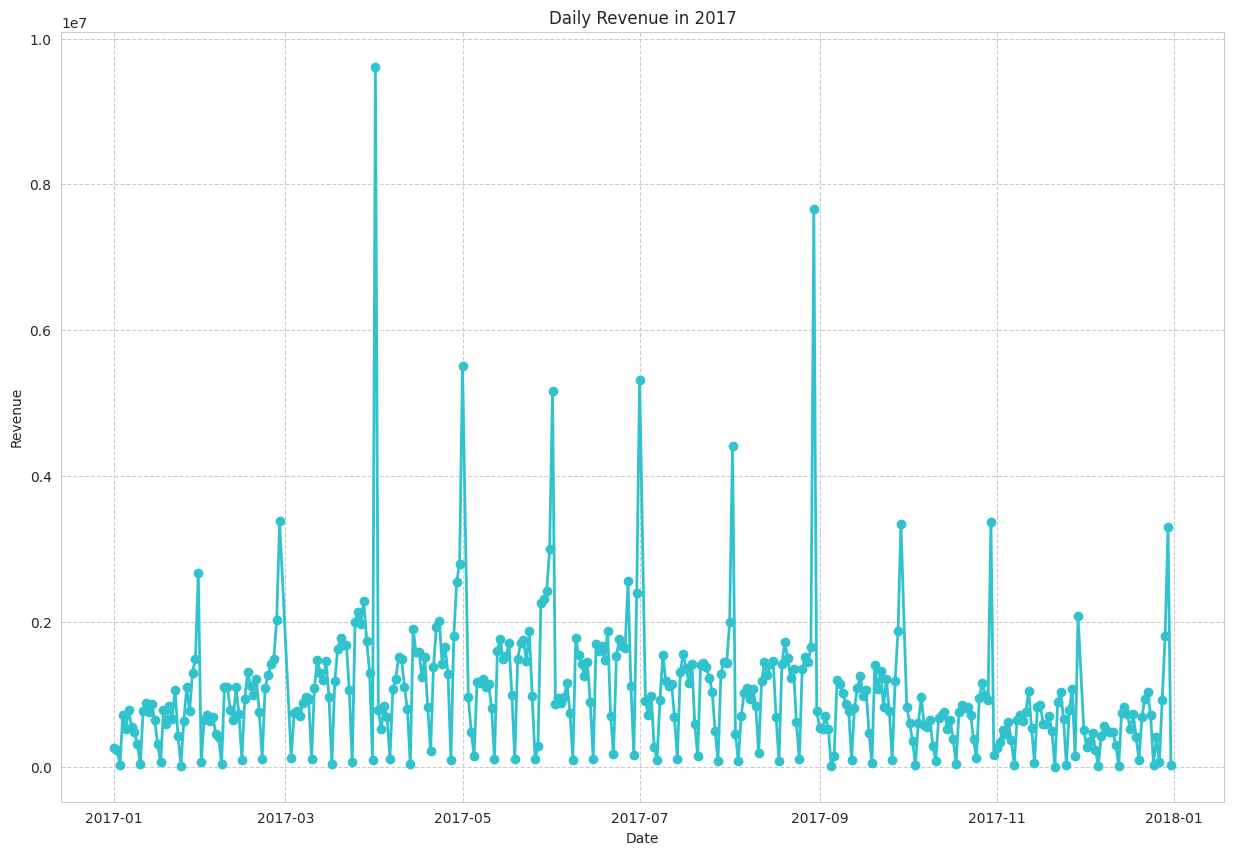

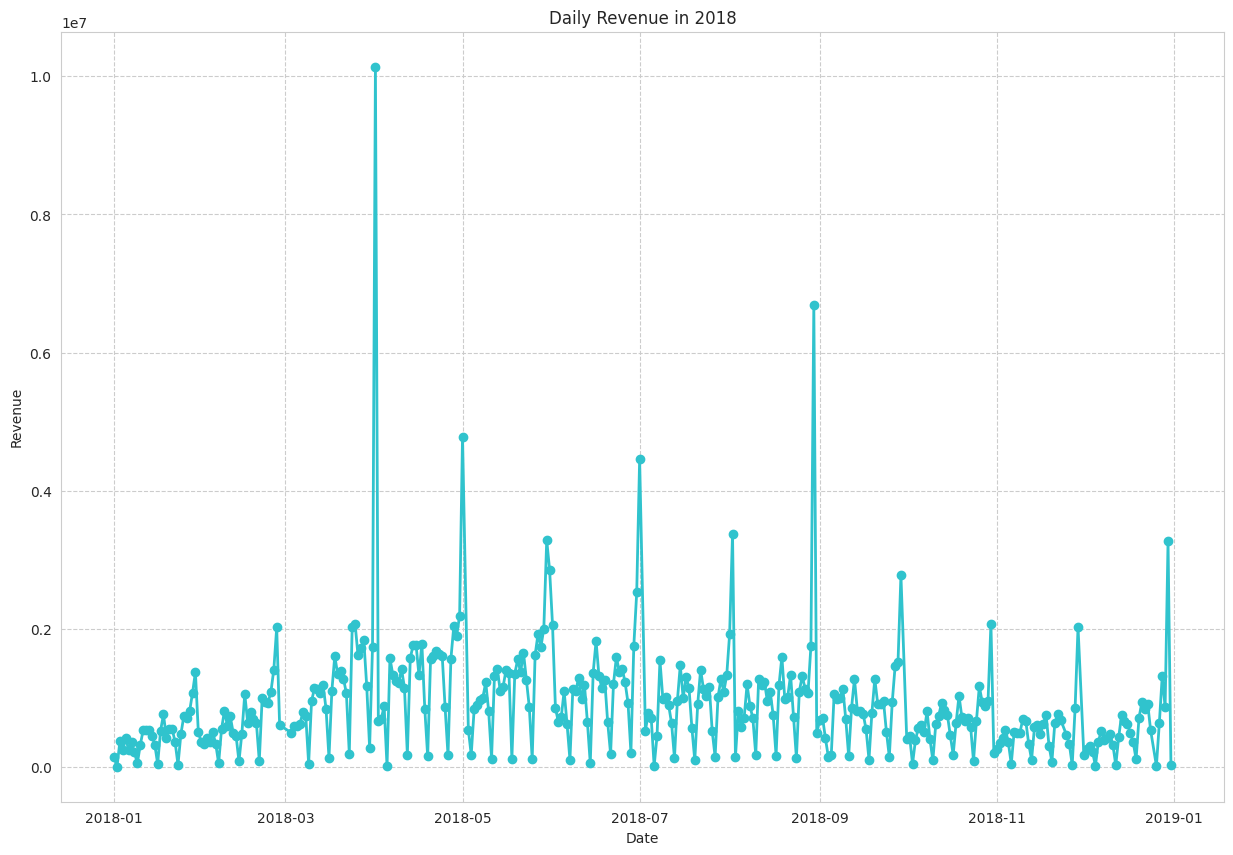

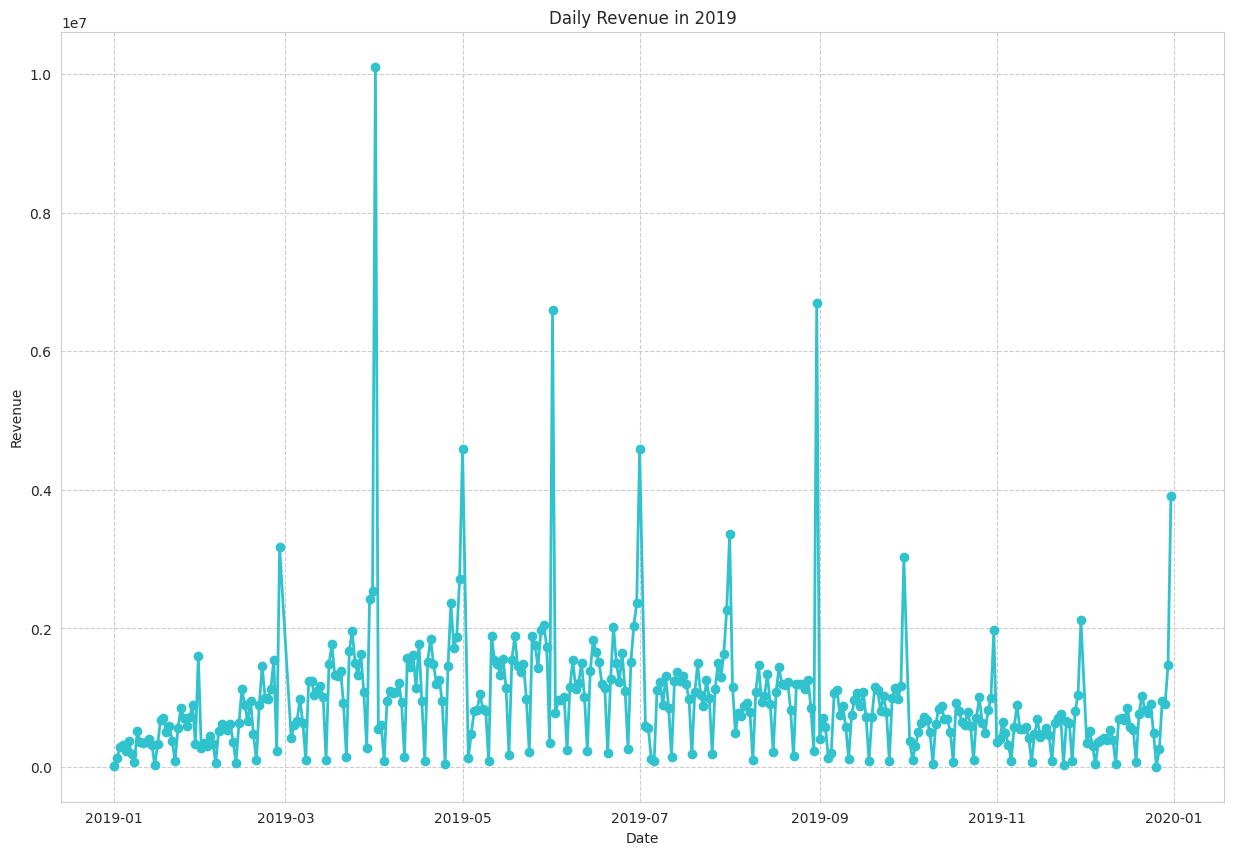

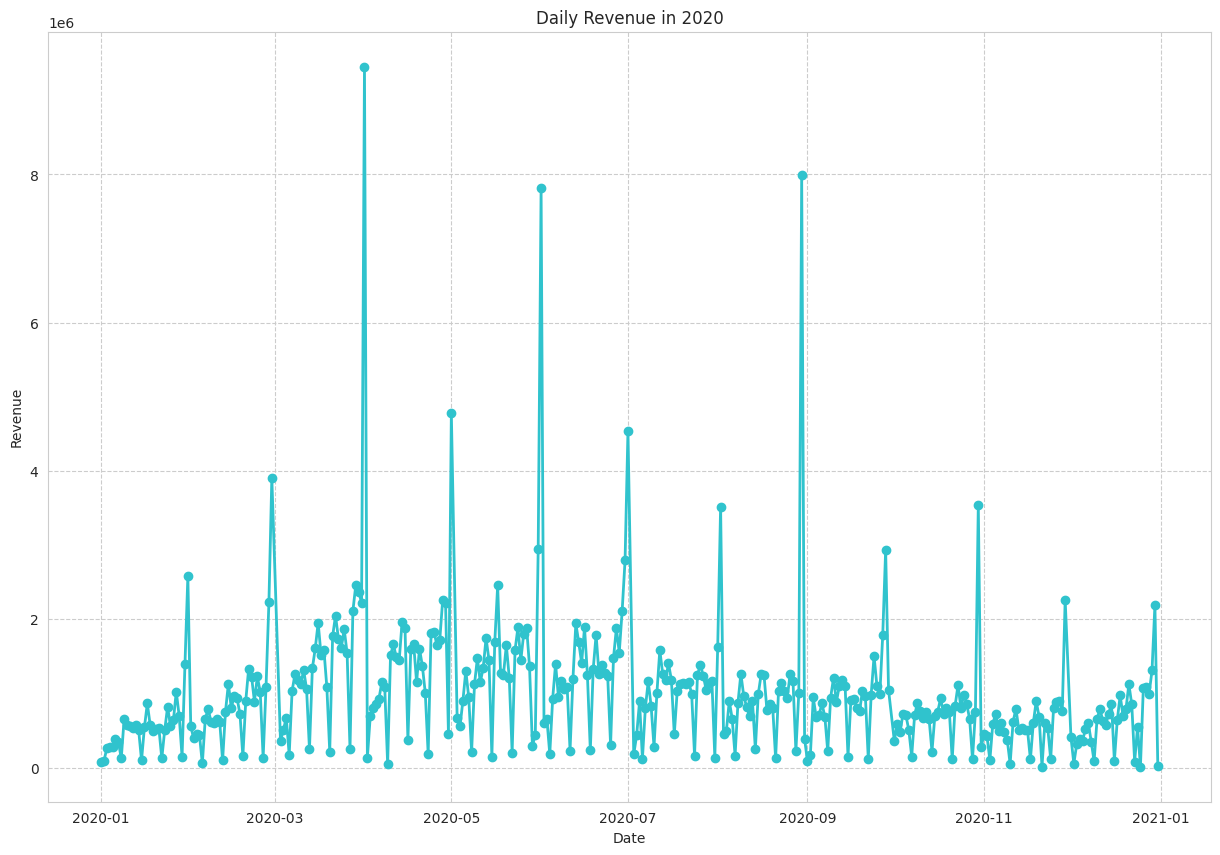

In [207]:
def yearly_revenue():
  for i in range(2010, 2021):
    plot_yearly_revenue(daily_revenue, i)

yearly_revenue()

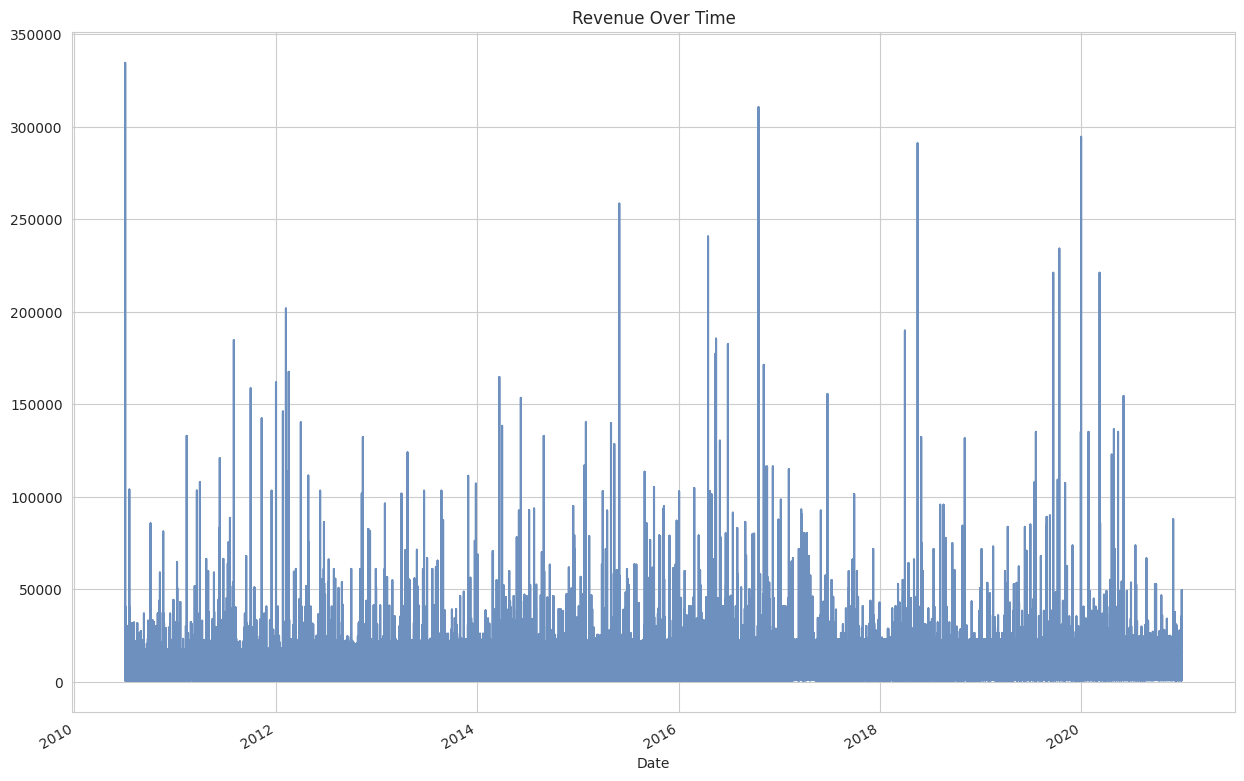

In [208]:
# Revenue Over Time Daily of Every Year
plt.figure(figsize=(15, 10))                                                  # Which product has the highest revenue ?
sale_train['Revenue'].plot(title='Revenue Over Time')                               # Which feature correlates most with target ?
plt.show()                                                                    # Are holidays affect the revenue ?
                                                                              # Revenue and zip based on zip code

----------- From the perspective of daily revenue, it's hard to deduce any useful insights.

### Group based on month

In [209]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_monthly_revenue(daily_revenue, start_year, end_year):
    daily_revenue['Date'] = pd.to_datetime(daily_revenue['Date'])  # Ensure Date is datetime
    daily_revenue['Year'] = daily_revenue['Date'].dt.year  # Extract year
    daily_revenue['Month'] = daily_revenue['Date'].dt.strftime('%Y-%m')  # Convert to year-month string

    monthly_revenue = daily_revenue.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
    years = range(start_year, end_year + 1)

    num_years = len(years)
    fig, axes = plt.subplots(num_years, 1, figsize=(12, 5 * num_years))

    if num_years == 1:
        axes = [axes]

    for ax, year in zip(axes, years):
        filtered_data = monthly_revenue[monthly_revenue['Year'] == year]
        ax.plot(filtered_data['Month'], filtered_data['Revenue'], marker='o', color='#30c3cd', linewidth=2)
        ax.set_title(f'Monthly Revenue in {year}')
        ax.set_xlabel('Year-Month')
        ax.set_ylabel('Revenue')
        ax.grid(True, linestyle='--')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



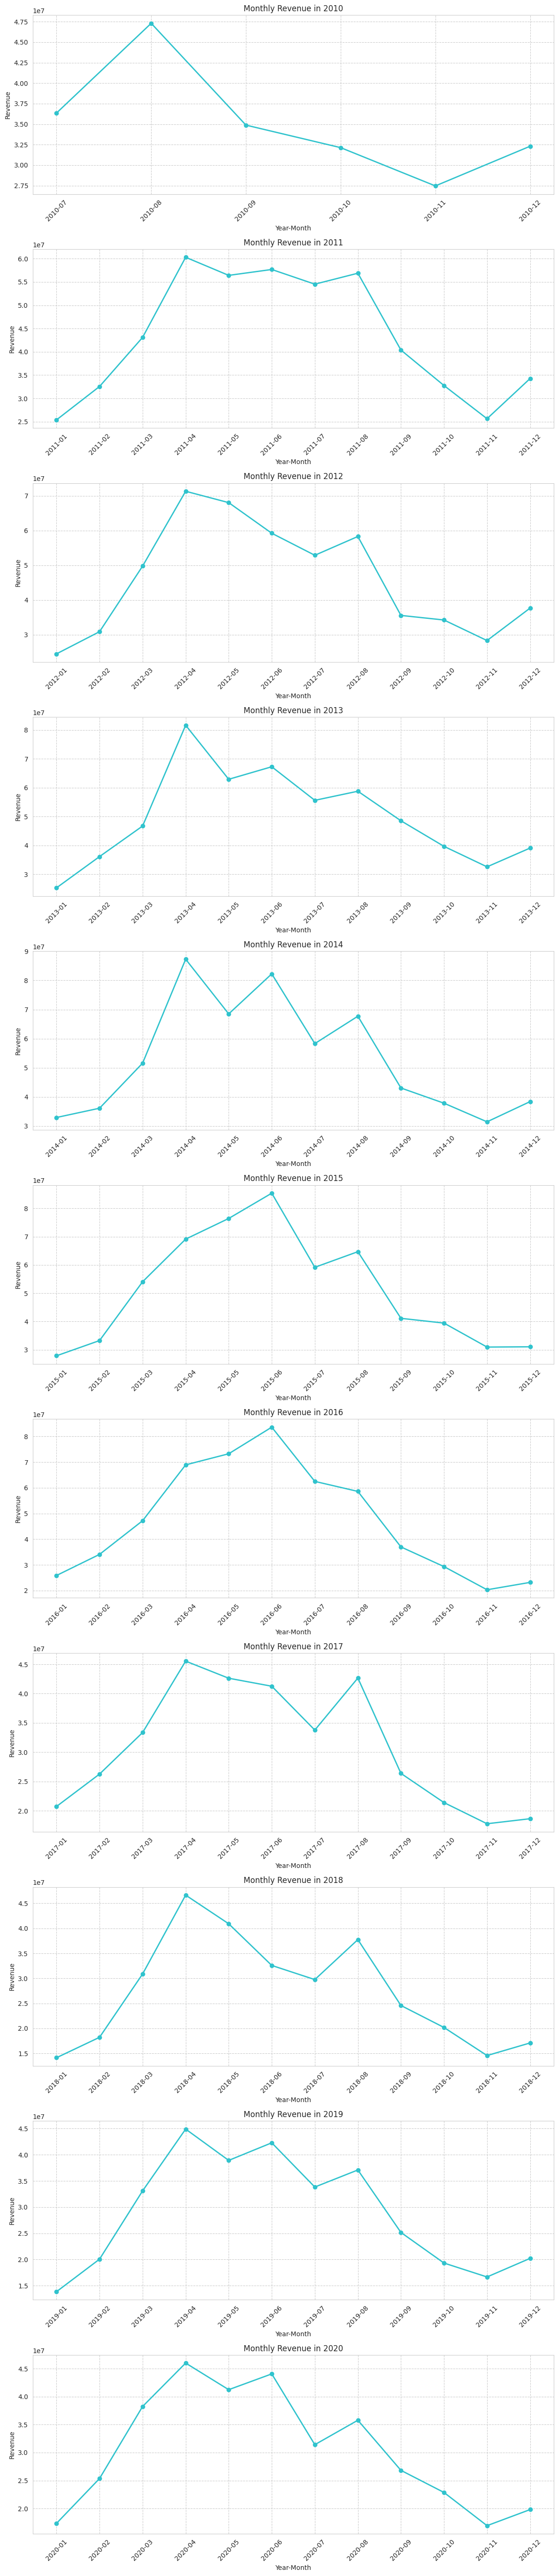

In [210]:
plot_monthly_revenue(daily_revenue, 2010, 2020)

In [211]:
daily_units = sale_train.groupby('Date')['Units'].sum().reset_index()

In [212]:
def plot_monthly_units(daily_units, start_year, end_year):
    daily_units['Date'] = pd.to_datetime(daily_units['Date'])  # Ensure Date is datetime
    daily_units['Year'] = daily_units['Date'].dt.year  # Extract year
    daily_units['Month'] = daily_units['Date'].dt.strftime('%Y-%m')  # Convert to year-month string

    monthly_revenue = daily_units.groupby(['Year', 'Month'])['Units'].sum().reset_index() # Changed 'daily_revenue' to 'daily_units'
    years = range(start_year, end_year + 1)

    num_years = len(years)
    fig, axes = plt.subplots(num_years, 1, figsize=(12, 5 * num_years))

    if num_years == 1:
        axes = [axes]

    for ax, year in zip(axes, years):
        filtered_data = monthly_revenue[monthly_revenue['Year'] == year]
        ax.plot(filtered_data['Month'], filtered_data['Units'], marker='o', color='#30c3cd', linewidth=2)
        ax.set_title(f'Monthly Units in {year}')
        ax.set_xlabel('Year-Month')
        ax.set_ylabel('Units')
        ax.grid(True, linestyle='--')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



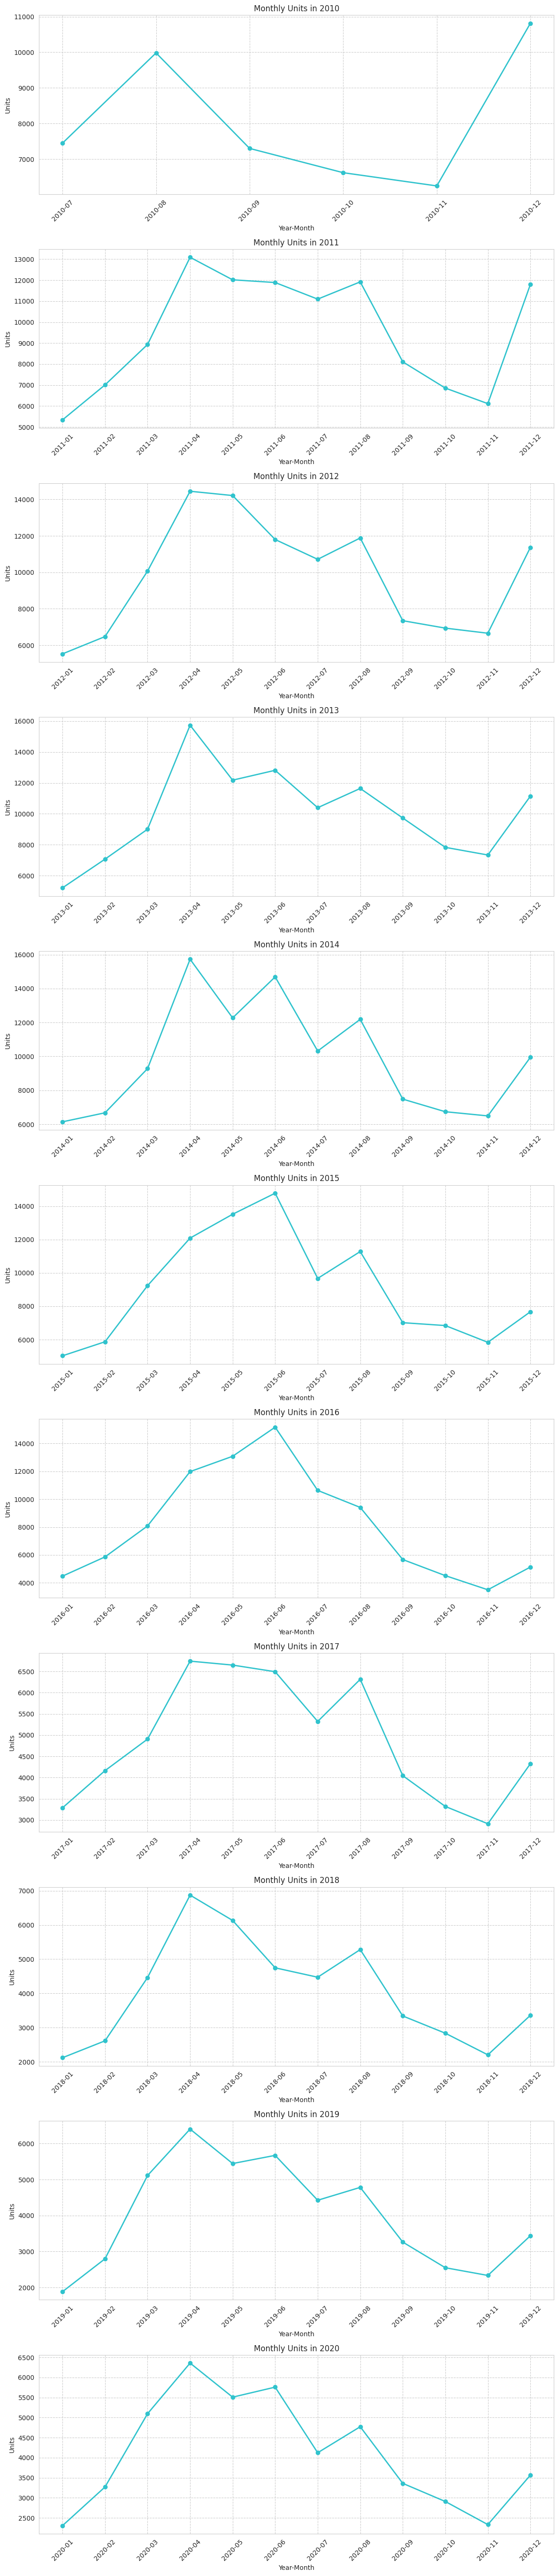

In [213]:
plot_monthly_units(daily_units, 2010, 2020)

--------From the above table, we can come to a conclusion that the company generates the most value and units in mid-year period.   
---------- Month may be an important features

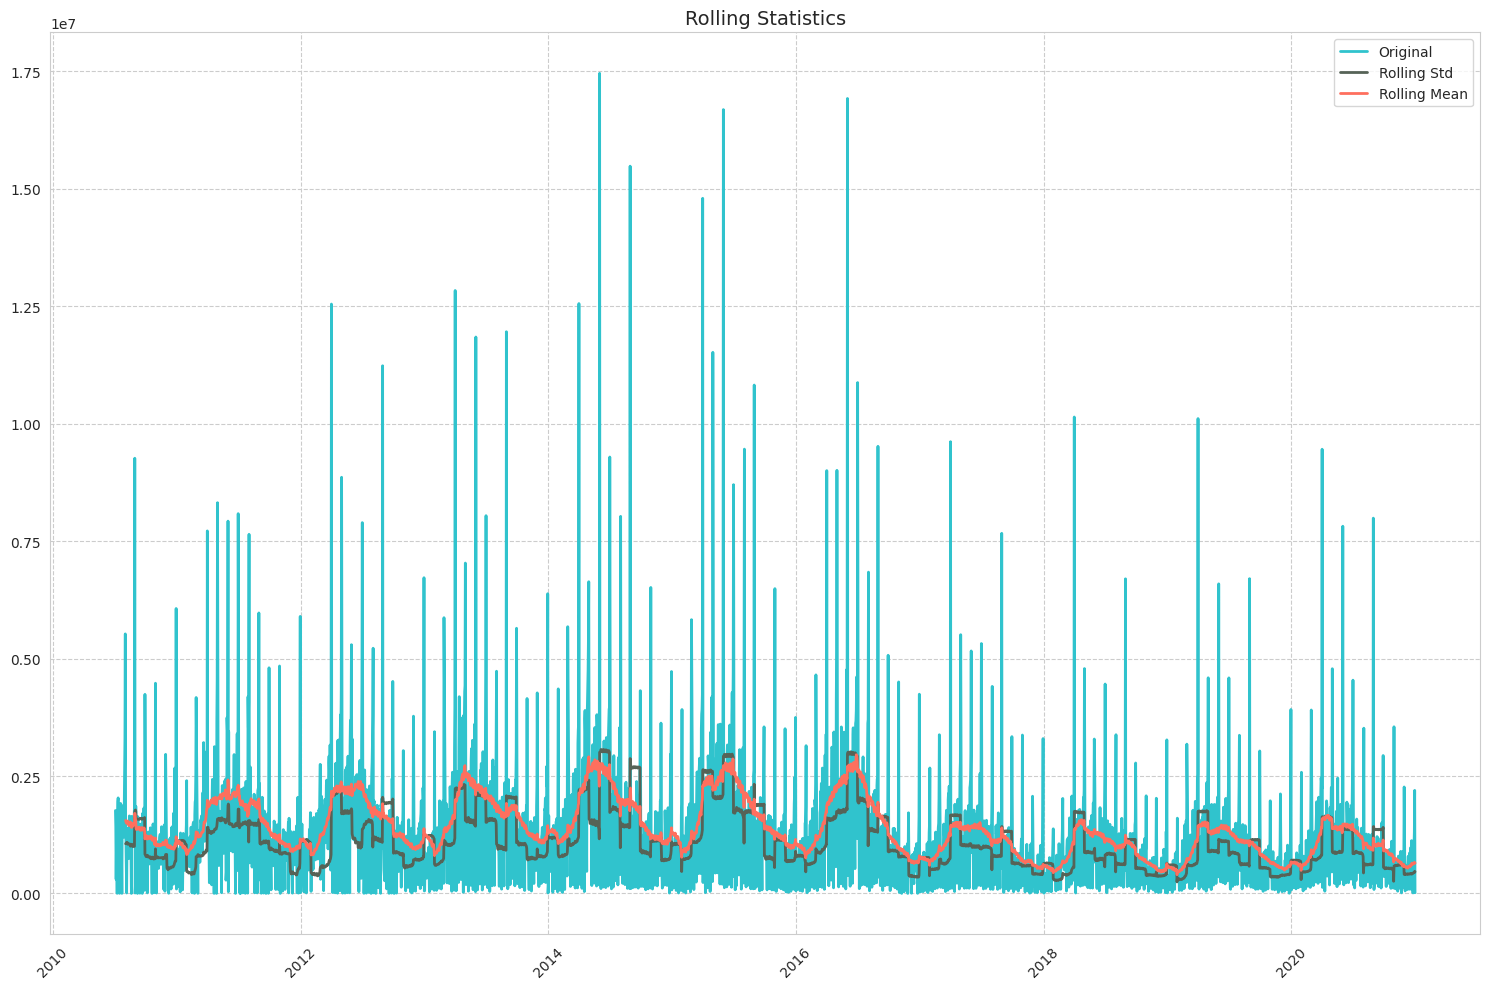

In [214]:
# Rolling Statistics
plt.figure(figsize=(15, 10))
rolling_mean = daily_revenue['Revenue'].rolling(window=30).mean()
rolling_std = daily_revenue['Revenue'].rolling(window=30).std()

plt.plot(daily_revenue['Date'], daily_revenue['Revenue'], color = '#30c3cd', label='Original', linewidth=2)
plt.plot(daily_revenue['Date'], rolling_std,color = '#566357', label='Rolling Std', linewidth=2)
plt.plot(daily_revenue['Date'], rolling_mean, color = '#fe6f5e', label='Rolling Mean', linewidth=2)


plt.title('Rolling Statistics', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

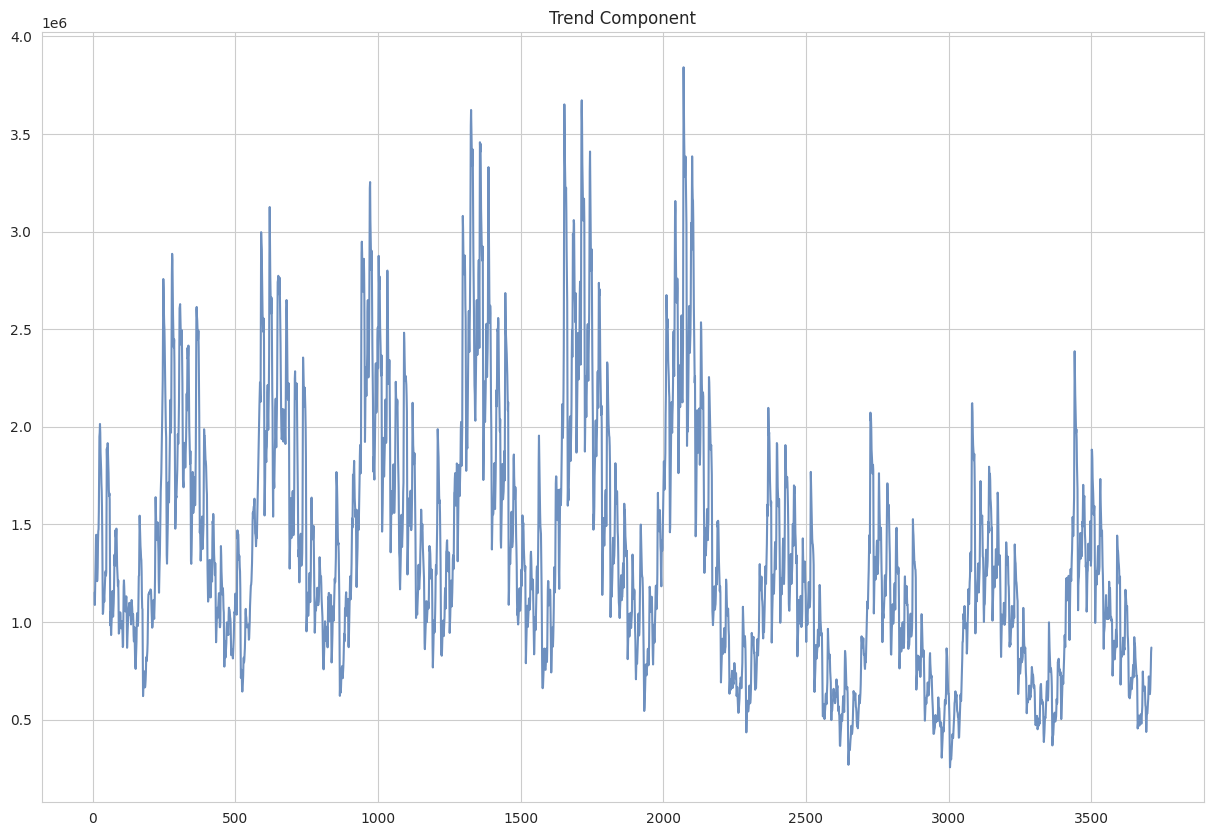

In [215]:
#Seasonal Decomposition
plt.figure(figsize=(15, 10))
decomposition = seasonal_decompose(daily_revenue['Revenue'], period=12)
decomposition.trend.plot(title='Trend Component')

plt.show()


## Correlation

In [216]:
correlations_revenue = sale_train.corr(numeric_only= True)['Revenue'].sort_values(ascending = True)
print(f"Most positive correlations with revenue: \n {correlations_revenue.tail(3)}")
print(f"Most negative correlations with revenue: \n {correlations_revenue.head(3)}")

Most positive correlations with revenue: 
 Units      0.325752
COGS       0.951023
Revenue    1.000000
Name: Revenue, dtype: float64
Most negative correlations with revenue: 
 ProductID   -0.365078
Zip         -0.061770
Units        0.325752
Name: Revenue, dtype: float64
